In [1]:
%pip install radler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 3.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import astropy.units as au
import matplotlib.pyplot as plt
import numpy as np
import radler
import xarray as xr
import xradio.vis.convert_msv2_to_processing_set as convert_msv2_to_processing_set
import xradio.vis.read_processing_set as read_processing_set
from astropy.io import fits

from ska_sdp_spectral_line_imaging.data_procs.imaging import cube_imaging
from ska_sdp_spectral_line_imaging.data_procs.predict import predict

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
from dask.distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35041,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.20 GiB
Comm: tcp://127.0.0.1:44435,Total threads: 4
Dashboard: http://127.0.0.1:39129/status,Memory: 15.55 GiB
Nanny: tcp://127.0.0.1:33221,


In [3]:
# wget https://support.astron.nl/software/ci_data/radler/mwa-vela.tar.bz2

In [4]:
msname = "SKA1-LOW_AA4_150MHz_CH151_SPECTRAL_CONTINUUM.ms/"
psname = "SKA1-LOW_AA4_150MHz_CH151_SPECTRAL_CONTINUUM.ps/"

In [5]:
# convert_msv2_to_processing_set(in_file=msname, out_file=psname, main_chunksize=dict(frequency=4), overwrite=True)

In [6]:
ps_raw = read_processing_set(psname)
ps = ps_raw.get(0)

In [7]:
ps_raw.summary()

,name,obs_mode,shape,polarization,spw_id,field_name,source_name,field_coords,start_frequency,end_frequency
0,_0,OBSERVE_TARGET#ON_SOURCE,"(120, 130816, 151, 1)",[XX],0,[_0],[Unknown],"[fk5, 15h00m00.00s, -30d00m00.00s]",142500000.0,157500000.0


In [8]:
ps = ps.unify_chunks()
ps

<xarray.Dataset> Size: 31GB
Dimensions:                     (time: 120, baseline_id: 130816,
                                 frequency: 151, polarization: 1, uvw_label: 3)
Coordinates:
    baseline_antenna1_id        (baseline_id) int32 523kB dask.array<chunksize=(65408,), meta=np.ndarray>
    baseline_antenna2_id        (baseline_id) int32 523kB dask.array<chunksize=(65408,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 1MB 0 1 2 ... 130814 130815
  * frequency                   (frequency) float64 1kB 1.425e+08 ... 1.575e+08
  * polarization                (polarization) <U2 8B 'XX'
  * time                        (time) float64 960B 9.467e+08 ... 9.467e+08
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 126MB dask.array<chunksize=(120, 65408), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 2GB dask.array<chunksize=(120, 65408, 4, 1), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 126MB dask.array<chunksize=(120, 65408), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 377MB dask.array<chunksize=(120, 65408, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 19GB dask.array<chunksize=(120, 65408, 4, 1), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 9GB dask.array<chunksize=(120, 65408, 4, 1), meta=np.ndarray>
Attributes:
    data_groups:     {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'V...
    partition_info:  {'field_id': [0], 'field_name': ['_0'], 'obs_mode': 'OBS...
    antenna_xds:     <xarray.Dataset> Size: 66kB\nDimensions:        (antenna...
    pointing_xds:    <xarray.Dataset> Size: 0B\nDimensions:  ()\nData variabl...

In [9]:
pixel_scale = (16 * au.arcsecond).to(au.rad).value
epsilon = 1e-4
nx = 1024
ny = 1024

In [10]:
def cont_imaging(ps, nx, ny, pixel_scale, epsilon=1e-4):
    template_core_dims = ["frequency", "polarization", "ra", "dec"]
    template_chunk_sizes = {
        k: v for k, v in ps.chunksizes.items() if k in template_core_dims
    }
    output_xr = xr.DataArray(
        np.empty(
            (
                ps.sizes["frequency"],
                ps.sizes["polarization"],
                nx,
                ny,
            )
        ),
        dims=template_core_dims,
    ).chunk(template_chunk_sizes)

    image_cube = xr.map_blocks(
        cube_imaging,
        ps,
        template=output_xr,
        kwargs=dict(
            nx=nx,
            ny=ny,
            epsilon=epsilon,
            cell_size=pixel_scale,
        ),
    )

    image_cont = image_cube.mean(dim=["frequency"])
    return image_cont

In [11]:
image_cont = cont_imaging(ps, nx, ny, pixel_scale, epsilon)

In [12]:
dirty_image_task = image_cont[0].astype(np.float32)
dirty_image = dirty_image_task.compute()

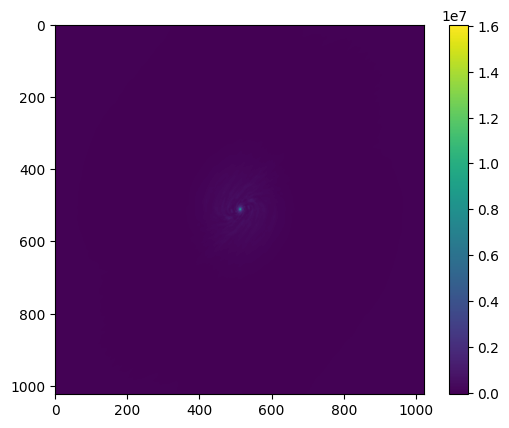

In [13]:
plt.imshow(dirty_image)
plt.colorbar()

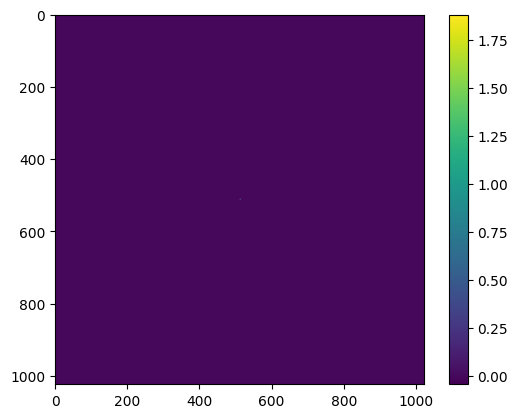

In [35]:
wsclean_image = "SKA1_low_cont-dirty.fits"
# dirty_image = "wsclean-dirty.fits"
with fits.open(wsclean_image) as im:
    im_data = im[0].data[0, 0].astype(np.float32)

plt.imshow(im_data)
plt.colorbar()

In [14]:
psf = "SKA1_low_cont-psf.fits"
# dirty_image = "wsclean-dirty.fits"
with fits.open(psf) as p:
    hdu = p[0]
    psf_data = p[0].data[0, 0].astype(np.float32)

---

## Multiscale deconvolution

In [15]:
settings = radler.Settings()
settings.algorithm_type = radler.AlgorithmType.multiscale

settings.trimmed_image_width, settings.trimmed_image_height = psf_data.shape
settings.pixel_scale.x = pixel_scale
settings.pixel_scale.y = pixel_scale
# Run up to 1 sigma. Such a low value is possible because of auto-masking.
settings.auto_threshold_sigma = 1
# When a 4-sigma threshold is reached, use the auto-mask.
settings.auto_mask_sigma = 4
settings.save_source_list = True
settings.major_loop_gain = 0.8
# settings.allow_negative_components = True
settings.major_iteration_count = 5
settings.minor_iteration_count = 20000

In [16]:
def plot_input(residual, psf):
    plt.subplots(figsize=(16, 8))
    plt.suptitle("input images")

    plt.subplot(1, 2, 1)
    plt.title("Residual (dirty image)")
    plt.imshow(residual)

    plt.subplot(1, 2, 2)
    plt.title("psf image")
    plt.imshow(psf)

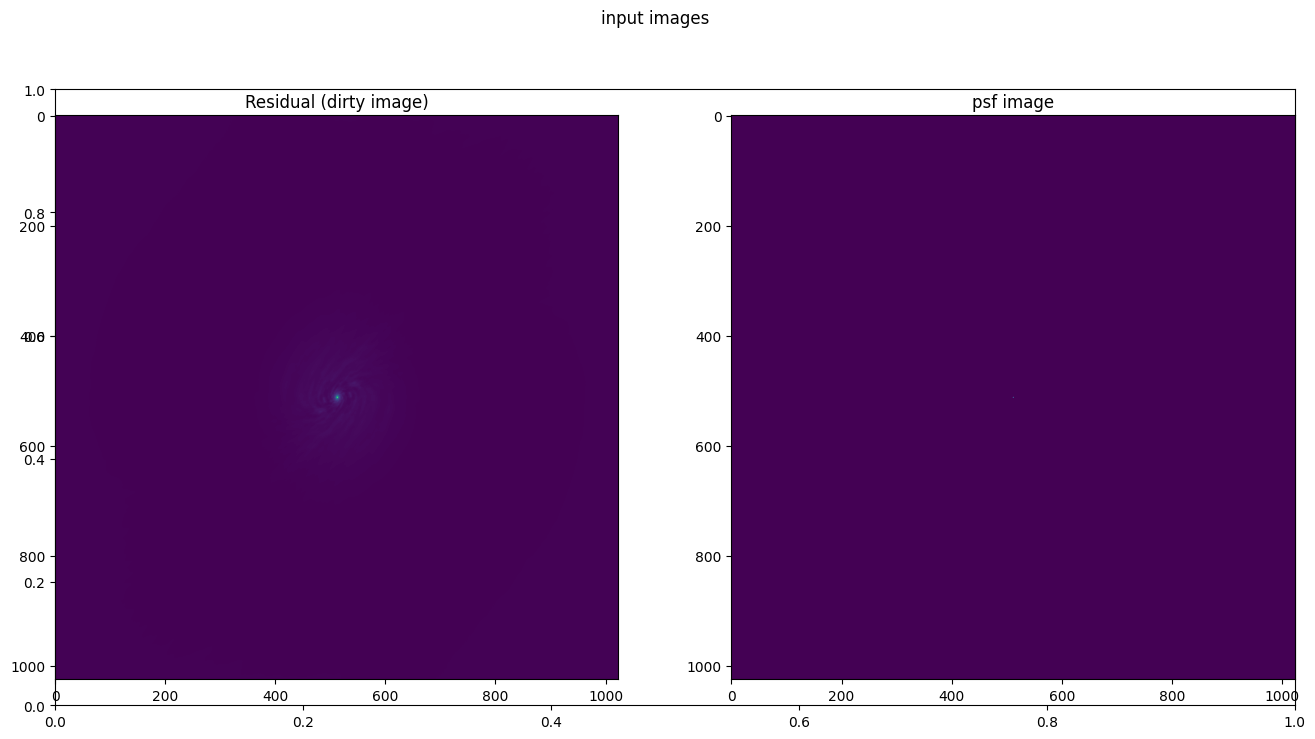

In [17]:
plot_input(dirty_image, psf_data)

In [18]:
model = np.zeros_like(dirty_image)

In [19]:
beam_size = (740.91 * 1e-3 * au.arcsec).to(au.rad).value

In [20]:
# TODO: Revisit beam size
deconvolver = radler.Radler(
    settings,
    psf_data,
    dirty_image.data,
    model,
    beam_size,
    radler.Polarization.xx,
)

 == Deconvolving (0) ==
Estimated standard deviation of background noise: 36.93 KJy
Scale info:
- Scale 0, bias factor=1, psfpeak=1, gain=0.1, kernel peak=1
- Scale 0, bias factor=1.7, psfpeak=1, gain=0.1, kernel peak=1
- Scale 0, bias factor=2.8, psfpeak=1, gain=0.1, kernel peak=1
- Scale 1, bias factor=4.6, psfpeak=1, gain=0.1, kernel peak=1
- Scale 1, bias factor=7.7, psfpeak=0.462916, gain=0.216022, kernel peak=0.463074
- Scale 3, bias factor=12.9, psfpeak=0.155912, gain=0.641387, kernel peak=0.155968
- Scale 6, bias factor=21.4, psfpeak=0.0748338, gain=1.33629, kernel peak=0.074776
- Scale 12, bias factor=35.7, psfpeak=0.0238024, gain=4.20126, kernel peak=0.0237725
- Scale 24, bias factor=59.5, psfpeak=0.0068186, gain=14.6658, kernel peak=0.00681075
- Scale 47, bias factor=99.2, psfpeak=0.00183172, gain=54.5935, kernel peak=0.00183124
- Scale 95, bias factor=165.4, psfpeak=0.000473731, gain=211.09, kernel peak=0.000475387
- Scale 190, bias factor=275.6, psfpeak=0.000121331, gain=8

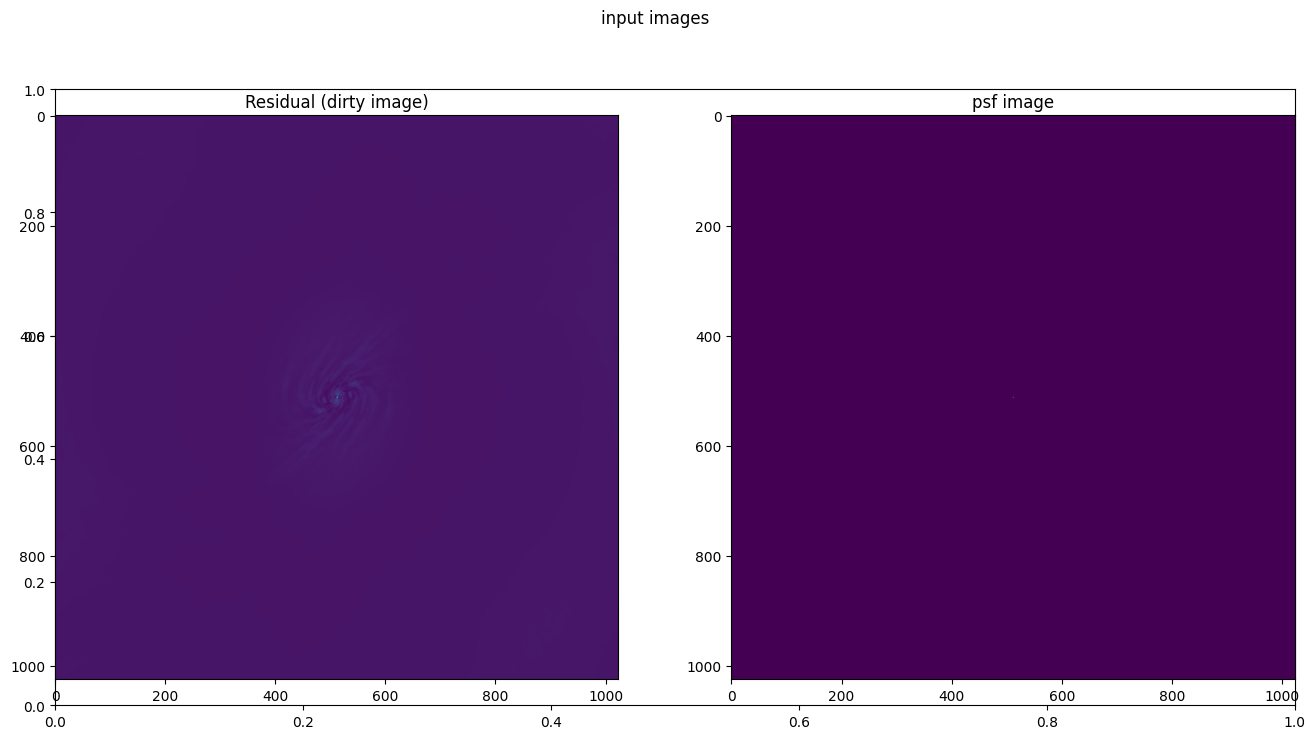

In [21]:
iteration = 0

reached_threshold = deconvolver.perform(iteration)

plot_input(dirty_image, psf_data)
print(f"Reached Threshold: {reached_threshold}")

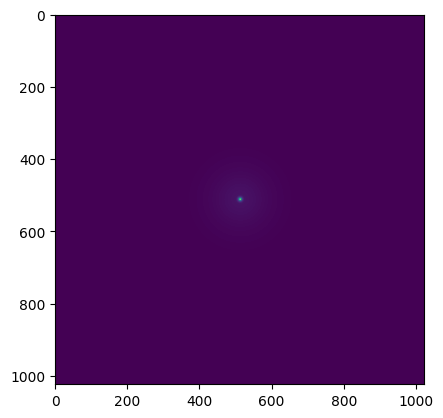

In [22]:
plt.imshow(model)

In [23]:
template_core_dims = ["frequency", "polarization", "time", "baseline_id"]
template_chunk_sizes = {
    k: v for k, v in ps.chunksizes.items() if k in template_core_dims
}
output_xr = xr.DataArray(
    np.empty(
        (
            ps.sizes["frequency"],
            ps.sizes["polarization"],
            ps.sizes["time"],
            ps.sizes["baseline_id"],
        ),
        dtype=np.complex64,
    ),
    dims=template_core_dims,
).chunk(template_chunk_sizes)

model_vis_task = xr.map_blocks(
    predict,
    ps,
    template=output_xr,
    kwargs=dict(
        model_image=model,
        epsilon=epsilon,
        cell_size=pixel_scale,
    ),
)

In [24]:
residual_ps = ps.assign({"VISIBILITY": ps.VISIBILITY - model_vis_task})
residual_ps

<xarray.Dataset> Size: 31GB
Dimensions:                     (time: 120, baseline_id: 130816,
                                 frequency: 151, polarization: 1, uvw_label: 3)
Coordinates:
    baseline_antenna1_id        (baseline_id) int32 523kB dask.array<chunksize=(65408,), meta=np.ndarray>
    baseline_antenna2_id        (baseline_id) int32 523kB dask.array<chunksize=(65408,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 1MB 0 1 2 ... 130814 130815
  * frequency                   (frequency) float64 1kB 1.425e+08 ... 1.575e+08
  * polarization                (polarization) <U2 8B 'XX'
  * time                        (time) float64 960B 9.467e+08 ... 9.467e+08
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 126MB dask.array<chunksize=(120, 65408), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 2GB dask.array<chunksize=(120, 65408, 4, 1), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 126MB dask.array<chunksize=(120, 65408), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 377MB dask.array<chunksize=(120, 65408, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 19GB dask.array<chunksize=(120, 65408, 4, 1), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 9GB dask.array<chunksize=(120, 65408, 4, 1), meta=np.ndarray>
Attributes:
    data_groups:     {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'V...
    partition_info:  {'field_id': [0], 'field_name': ['_0'], 'obs_mode': 'OBS...
    antenna_xds:     <xarray.Dataset> Size: 66kB\nDimensions:        (antenna...
    pointing_xds:    <xarray.Dataset> Size: 0B\nDimensions:  ()\nData variabl...

In [25]:
clean_image_1_task = cont_imaging(residual_ps, nx, ny, pixel_scale, epsilon)
clean_image_1_task

<xarray.DataArray (polarization: 1, ra: 1024, dec: 1024)> Size: 8MB
dask.array<mean_agg-aggregate, shape=(1, 1024, 1024), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Dimensions without coordinates: polarization, ra, dec

In [26]:
clean_image_cycle_1 = clean_image_1_task.astype(np.float32).compute()

In [27]:
clean_image_cycle_1 = clean_image_cycle_1.astype(np.float32)[0]
clean_image_cycle_1

<xarray.DataArray (ra: 1024, dec: 1024)> Size: 4MB
array([[-1.6724286e+13, -1.7058369e+13, -1.7390919e+13, ...,
        -1.8612803e+13, -1.8587631e+13, -1.8561473e+13],
       [-1.6938104e+13, -1.7273984e+13, -1.7608531e+13, ...,
        -1.8863895e+13, -1.8839679e+13, -1.8813288e+13],
       [-1.7150985e+13, -1.7488097e+13, -1.7824456e+13, ...,
        -1.9107301e+13, -1.9082892e+13, -1.9055082e+13],
       ...,
       [-1.9250842e+13, -1.9285257e+13, -1.9315324e+13, ...,
        -1.8375300e+13, -1.8038846e+13, -1.7701343e+13],
       [-1.9023142e+13, -1.9055080e+13, -1.9082892e+13, ...,
        -1.8159231e+13, -1.7824460e+13, -1.7488102e+13],
       [-1.8783763e+13, -1.8813286e+13, -1.8839677e+13, ...,
        -1.7941385e+13, -1.7608535e+13, -1.7273988e+13]], dtype=float32)
Dimensions without coordinates: ra, dec

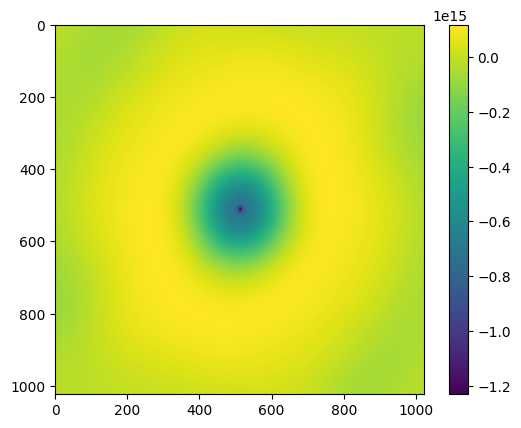

In [28]:
plt.imshow(clean_image_cycle_1)
plt.colorbar()

In [29]:
iteration += 1

deconvolver = radler.Radler(
    settings,
    psf_data,
    clean_image_cycle_1.data,
    model,
    0.0,
    radler.Polarization.xx,
)
reached_threshold = deconvolver.perform(iteration)

print(f"Reached Threshold: {reached_threshold}")

 == Deconvolving (1) ==
Estimated standard deviation of background noise: 8.21686e+10 KJy
Scale info:
- Scale 0, bias factor=1, psfpeak=1, gain=0.1, kernel peak=0.345507
- Scale 4, bias factor=1.7, psfpeak=0.136595, gain=0.732093, kernel peak=0.136619
- Scale 8, bias factor=2.8, psfpeak=0.0471431, gain=2.1212, kernel peak=0.0470832
- Scale 16, bias factor=4.6, psfpeak=0.0142839, gain=7.00087, kernel peak=0.0142657
- Scale 32, bias factor=7.7, psfpeak=0.00396803, gain=25.2014, kernel peak=0.00396448
- Scale 64, bias factor=12.9, psfpeak=0.00104713, gain=95.4987, kernel peak=0.00104784
- Scale 128, bias factor=21.4, psfpeak=0.000267561, gain=373.747, kernel peak=0.000269545
- Scale 256, bias factor=35.7, psfpeak=6.61222e-05, gain=1512.35, kernel peak=6.83685e-05
RMS per scale: {0: 1.20121e+11 KJy, 4: 1.20106e+11 KJy, 8: 1.20081e+11 KJy, 16: 1.20002e+11 KJy, 32: 1.19737e+11 KJy, 64: 1.18799e+11 KJy, 128: 1.1533e+11 KJy, 256: 1.03207e+11 KJy}
Starting multi-scale cleaning. Start peak=-2.02

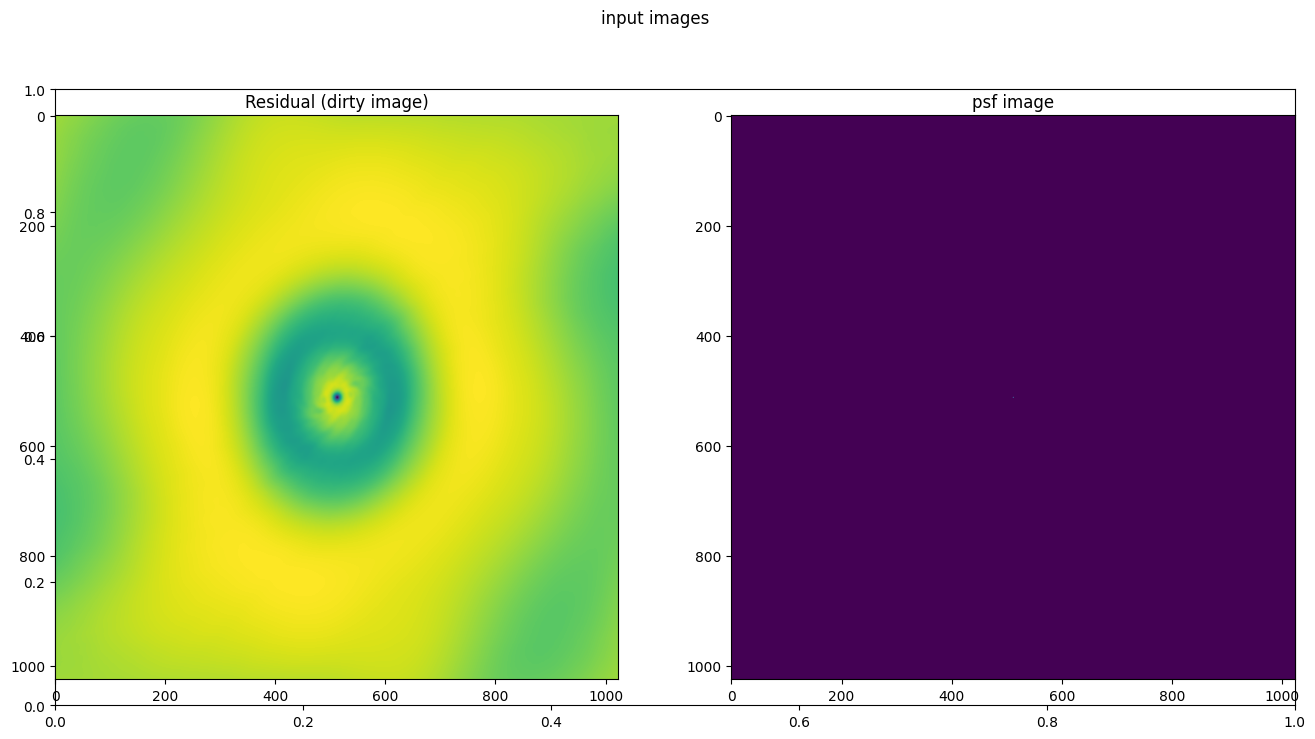

In [30]:
plot_input(clean_image_cycle_1, psf_data)

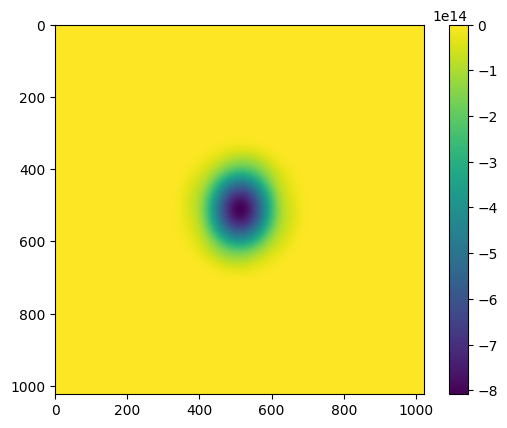

In [31]:
plt.imshow(model)
plt.colorbar()